# Potato Disease Classification
## Part 1: EDA

In [1]:
pip install matplotlib


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: C:\Users\user\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [40]:
# Declaring Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3 #RGB
EPOCHS = 30

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    seed = 123,
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [5]:
len(dataset)

68

Why it's 68, right? 68*32 equals the files 2152. length showing 68 because we chose batching before the training.

In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

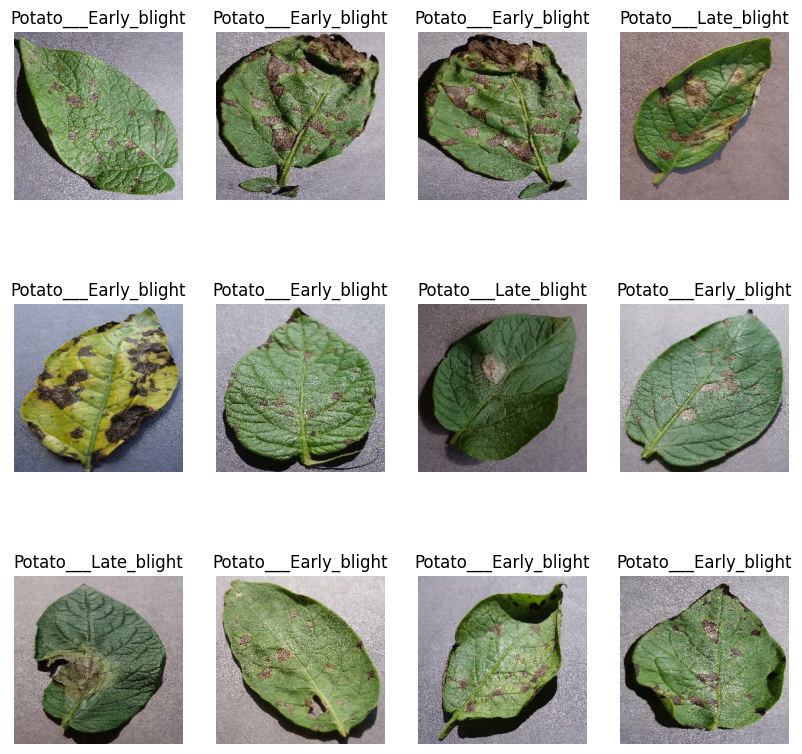

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Now, we'll put them all in a function to get it more precise!

In [15]:
def ds_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split + test_split + val_split == 1)
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = ds_partition(dataset)

Cache, Shuffling, and Prefetching Dataset

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the model

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## Data Augmentation

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture (CNN)

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
])

In [22]:
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compile the Model

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 85s 2s/step - loss: 0.5542 - accuracy: 0.7772 - val_loss: 0.5044 - val_accuracy: 0.7656
Epoch 2/30
54/54 [==============================] - 85s 2s/step - loss: 0.3952 - accuracy: 0.8380 - val_loss: 0.3844 - val_accuracy: 0.8229
Epoch 3/30
54/54 [==============================] - 85s 2s/step - loss: 0.3443 - accuracy: 0.8501 - val_loss: 0.3614 - val_accuracy: 0.8229
Epoch 4/30
54/54 [==============================] - 86s 2s/step - loss: 0.2719 - accuracy: 0.8912 - val_loss: 0.2879 - val_accuracy: 0.8542
Epoch 5/30
54/54 [==============================] - 86s 2s/step - loss: 0.2915 - accuracy: 0.8848 - val_loss: 0.3367 - val_accuracy: 0.8333
Epoch 6/30
54/54 [==============================] - 85s 2s/step - loss: 0.2327 - accuracy: 0.9080 - val_loss: 0.2248 - val_accuracy: 0.9167
Epoch 7/30
54/54 [==============================] - 85s 2s/step - loss: 0.1829 - accuracy: 0.9323 - val_loss: 0.1453 - val_accuracy: 0.9271
Epoch 8/30
54/54 [==

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 23s 395ms/step - loss: 0.4502 - accuracy: 0.8672


In [28]:
scores

[0.4501734972000122, 0.8671875]

## So, the test accuracy is 86%

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [32]:
len(history.history['loss'])

30

In [34]:
history.history['loss'][:5]

[0.5541958212852478,
 0.3952142596244812,
 0.3442840278148651,
 0.27188840508461,
 0.29149872064590454]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

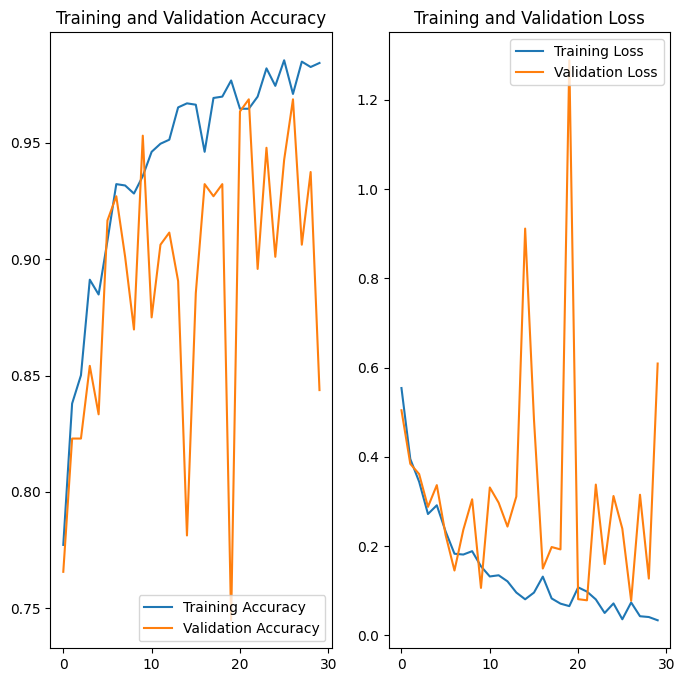

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sample Image Prediction

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 808ms/step
predicted label: Potato___Late_blight


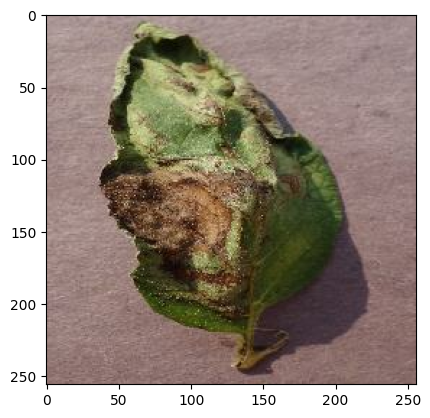

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Inference

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 53ms/step


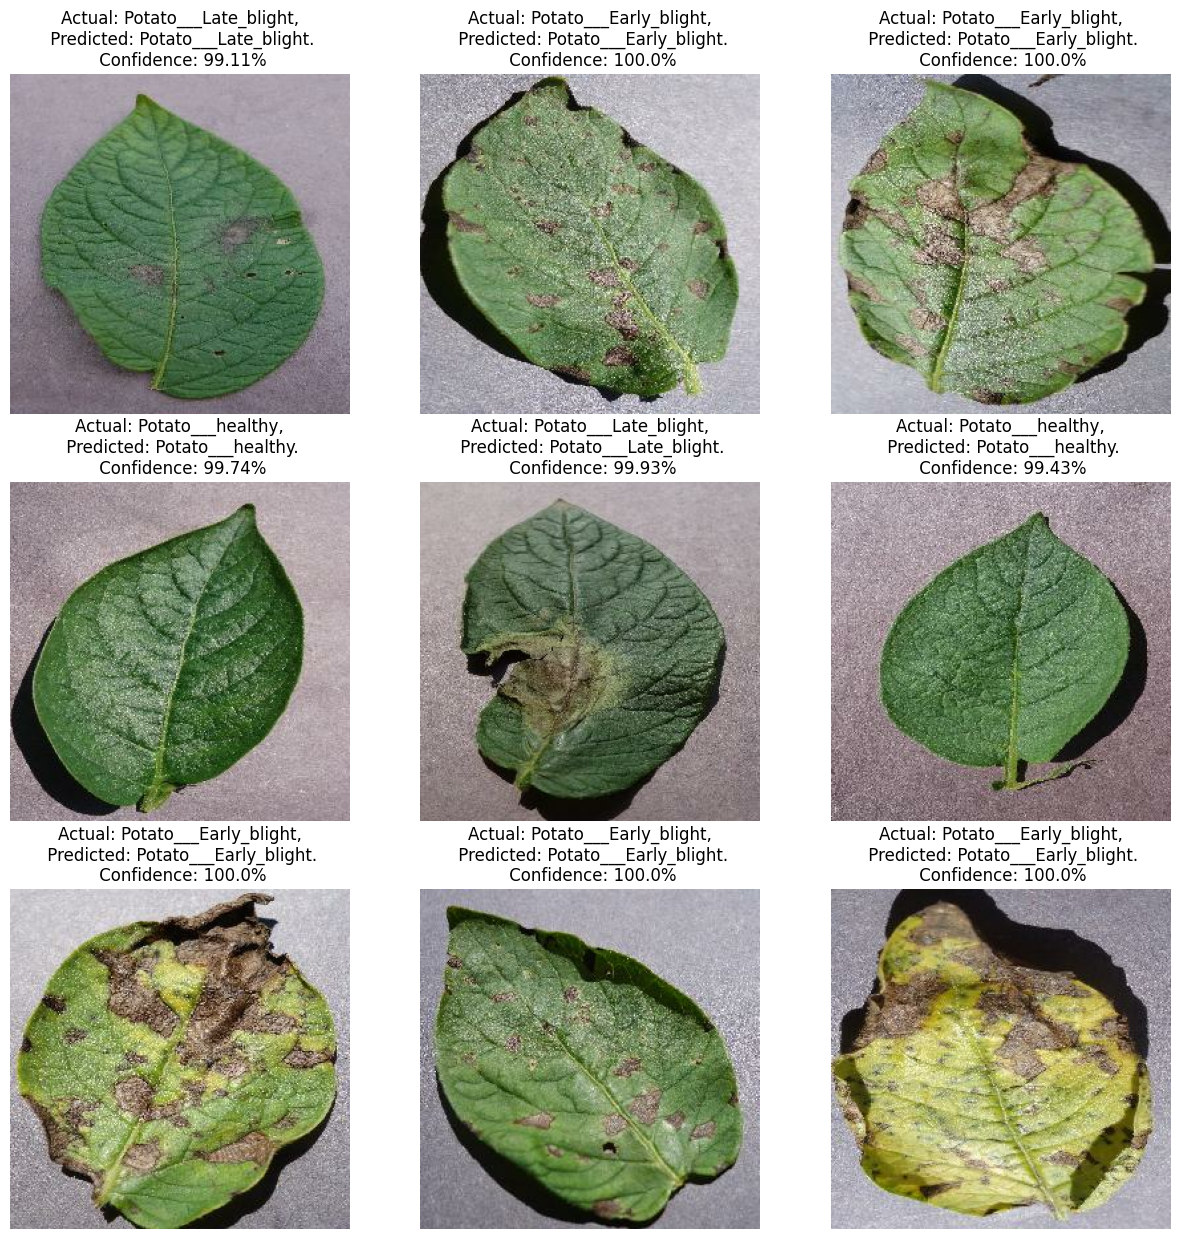

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Save the Model

In [46]:
model_path = 'D:/ML/Jupyter Notebook/potato/my_model'

model.save(model_path)

print(f"Model saved at: {model_path}")

INFO:tensorflow:Assets written to: D:/ML/Jupyter Notebook/potato/my_model\assets


INFO:tensorflow:Assets written to: D:/ML/Jupyter Notebook/potato/my_model\assets


Model saved at: D:/ML/Jupyter Notebook/potato/my_model
